In [2]:
# 统计DAS1K数据集中，所有数据的长度

In [3]:
from pathlib import Path
from hdf5storage import loadmat

def get_class_names(directory_path):
    # 转换为Path对象
    directory = Path(directory_path)
    # 确保路径存在且为目录
    if not directory.is_dir():
        raise ValueError(f"{directory_path} 不是一个有效的目录路径")
    
    # 创建一个集合来存储类别名，避免重复
    category_names = set()
    
    # 遍历主文件夹下的所有子文件夹
    for subfolder in directory.iterdir():
        if subfolder.is_dir():  # 检查是否为子文件夹
            # 遍历子文件夹中的文件
            category_names.add(subfolder.stem)
    
    # 返回类别名列表
    return list(category_names)

def get_iterfile_names(directory_path):
    # 转换为Path对象
    directory = Path(directory_path)
    # 确保路径存在且为目录
    if not directory.is_dir():
        raise ValueError(f"{directory_path} 不是一个有效的目录路径")
    
    # 创建一个集合来存储文件名，避免重复
    file_names = set()
    
    # 遍历主文件夹下的所有子文件夹
    for subfolder in directory.iterdir():
        if subfolder.is_file():  # 检查是否为子文件
            file_names.add(subfolder.stem)
    
    # 返回文件名列表
    return list(file_names)

def read_raw_signal_file(dataset_path, class_name, iterfile_name):
    iterfile_path = Path(dataset_path) / class_name / f"{iterfile_name}.mat"
    # mat = loadmat('/home/zhang/zxc/STFT_3DDL/DATASETS/raw_data/DAS1K/CARHORN/carhorn1.mat')
    mat = loadmat(str(iterfile_path))
    phase = mat[iterfile_name][0]
    intensity = mat[iterfile_name][1]
    # taxis = np.arange(len(phase))/10000
    # plt.figure(figsize=(15, 15))
    # plt.plot(taxis, phase)
    # plt.figure(figsize=(15, 15))
    # plt.plot(taxis, intensity)
    # print('test')
    return phase, intensity

dataset_path = Path('/home/zhang/zxc/STFT_3DDL/DATASETS/raw_data/DAS1K/')


In [4]:
# 先判断是否每条数据的phase和intensity长度相同
equal_length = True
class_names = get_class_names(dataset_path)
for class_name in class_names:
    iterfile_names = get_iterfile_names(dataset_path/class_name)
    for iterfile_name in iterfile_names:
        phase, intensity = read_raw_signal_file(dataset_path, class_name, iterfile_name)
        if len(phase) != len(intensity):
            equal_length = False
            print(f"class_name:{class_name}--iterfile_name:{iterfile_name}")
if equal_length == True:
    print("长度相同")
        

长度相同


最长：49450
最短：8986


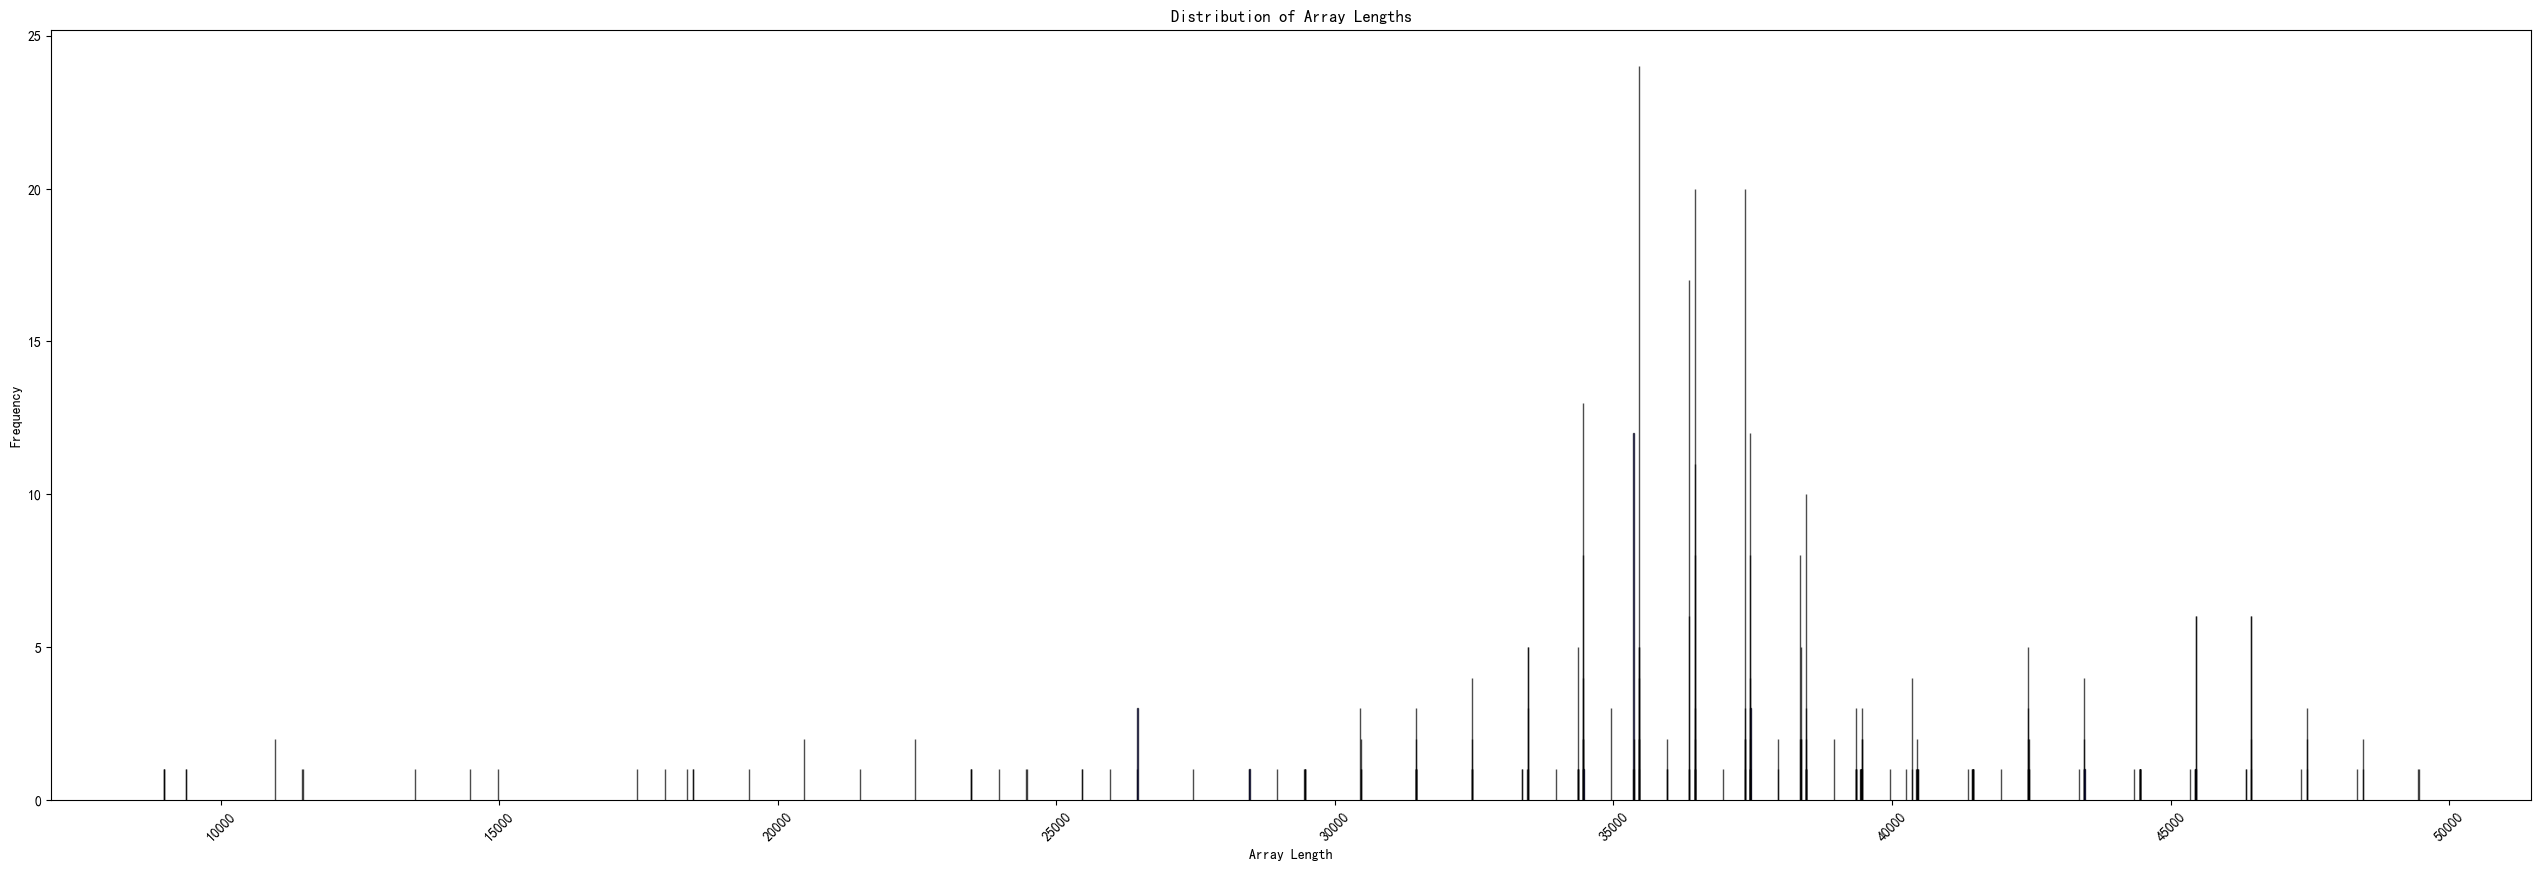

In [5]:
# 统计长度，画出值方图
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
lengths = []
class_names = get_class_names(dataset_path)
for class_name in class_names:
    iterfile_names = get_iterfile_names(dataset_path/class_name)
    for iterfile_name in iterfile_names:
        phase, intensity = read_raw_signal_file(dataset_path, class_name, iterfile_name)
        lengths.append(len(phase))

# 统计长度分布
lengths_counts = Counter(lengths)

# 输出最长长度和最短长度
max_lengths = max(lengths)
min_lengths = min(lengths)
print(f"最长：{max_lengths}")
print(f"最短：{min_lengths}")

# 提取数据用于绘图
length_values = list(lengths_counts.keys())
frequency = list(lengths_counts.values())

# 绘制值方图
plt.figure(figsize=(32, 10))
plt.bar(length_values, frequency, width=0.6, alpha=0.7, color='b', edgecolor='black')

plt.xlabel("Array Length")
plt.ylabel("Frequency")
plt.title("Distribution of Array Lengths")
plt.xticks(rotation=45)

# 显示图标
plt.show()




In [6]:
# 编写一个函数，输入是一个一维数组、最终长度、要padding的数值，对输入数组进行padding
def pad_array(arr, final_length, pad_value):
    """
    对一维数组进行 padding，使其长度达到 final_length
    :param arr: 输入的一维数组 (numpy array or list)
    :param final_length: 目标长度
    :param pad_value: 用于填充的数值
    :return: 填充后的 numpy 数组
    """
    arr = np.array(arr) # 确保输入是numpy数组
    current_length = len(arr)

    if current_length >= final_length:
        return arr[:final_length] # 如果长度大于等于目标长度，截断返回
    else:
        padding = np.full(final_length - current_length, pad_value) # 生成填充数组
        return np.concatenate((arr, padding)) # 连接原数组和填充部分
    

原始长度:37459


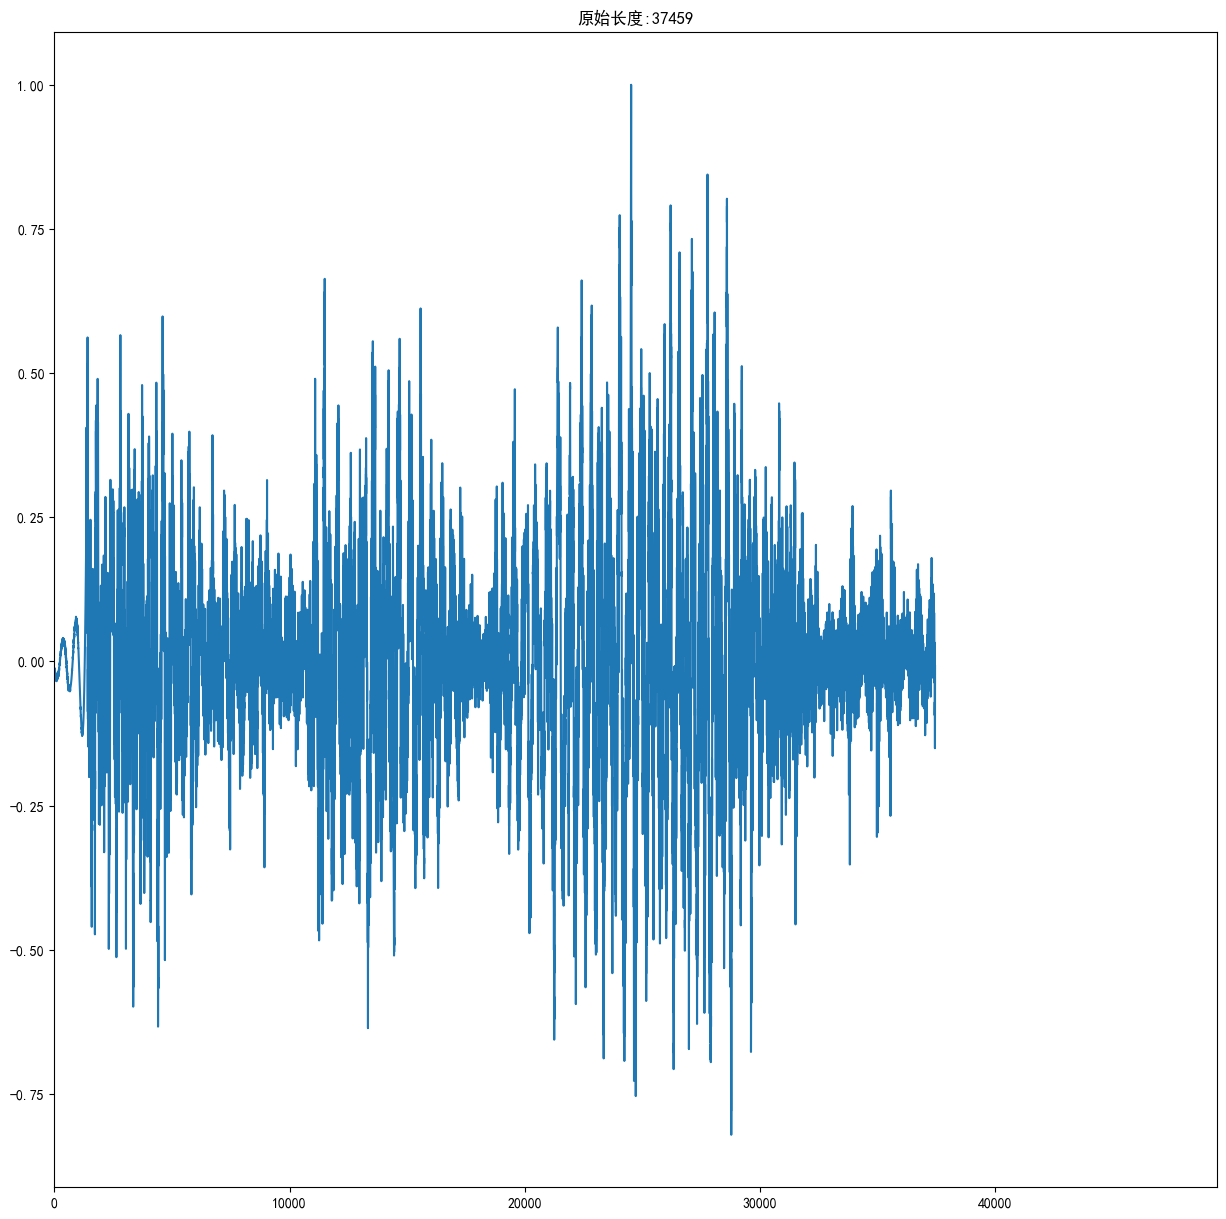

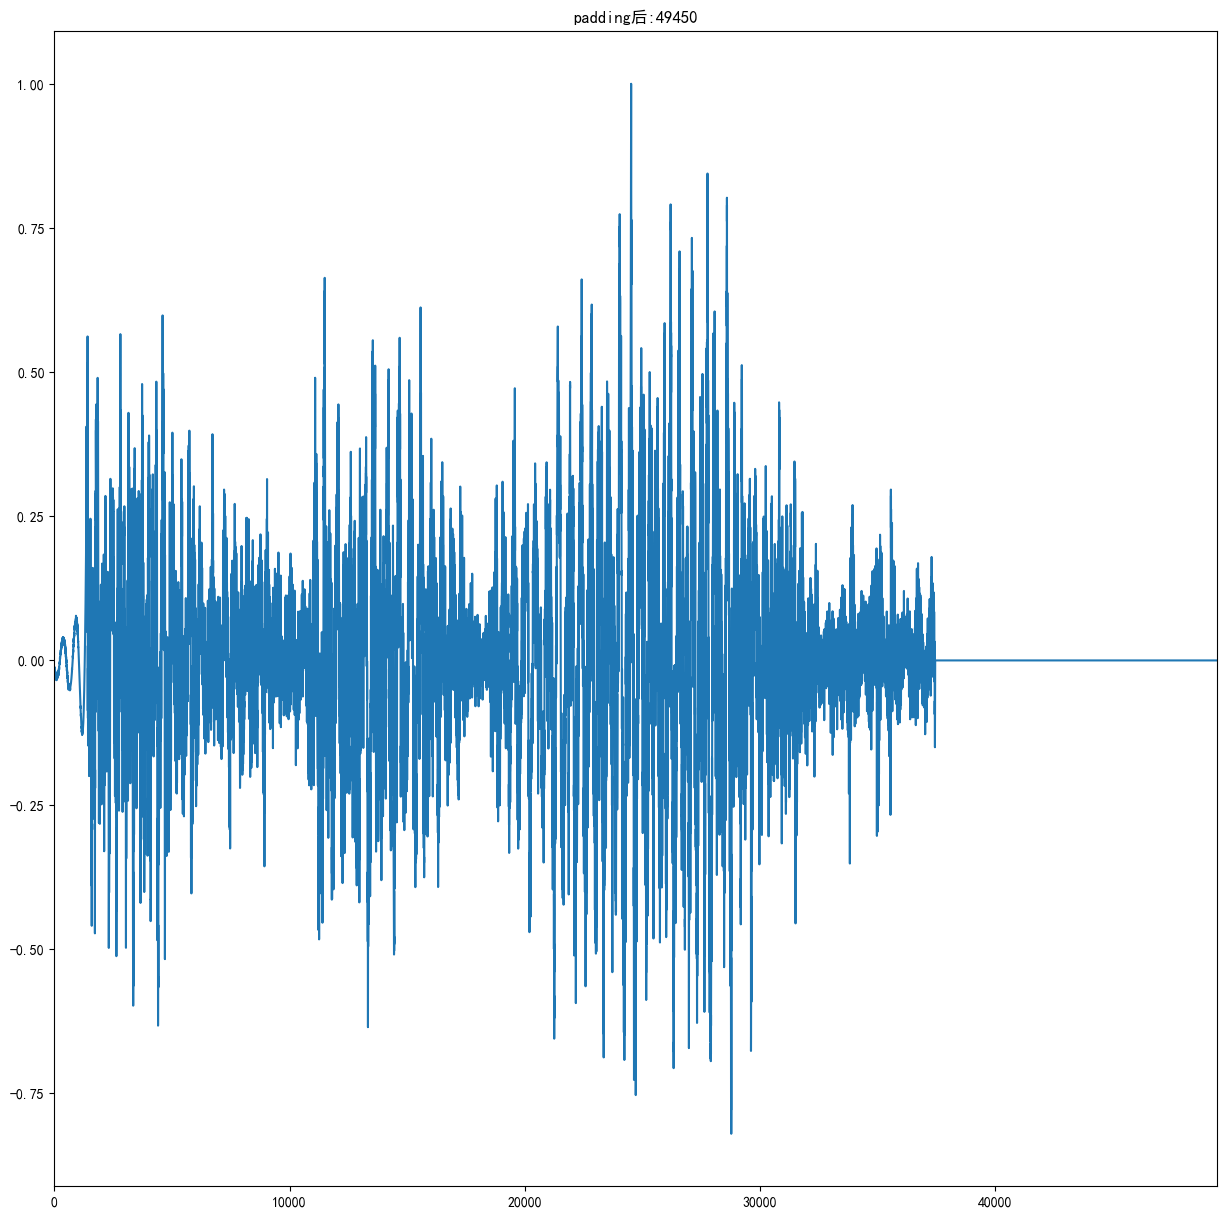

In [7]:
# 测试一个例子
class_name_0 = "CARHORN"
iterfile_name_0 = "carhorn29"

phase,_ = read_raw_signal_file(dataset_path, class_name_0, iterfile_name_0)
print(f"原始长度:{len(phase)}")

# 绘制原始图像
plt.figure(figsize=(15, 15))
plt.title(f"原始长度:{len(phase)}")
plt.plot(phase)
plt.xlim(0, max_lengths)
plt.show()

phase_padded = pad_array(phase, max_lengths, 0)

# 绘制padding后的图像
plt.figure(figsize=(15, 15))
plt.title(f"padding后:{len(phase_padded)}")
plt.plot(phase_padded)
plt.xlim(0, max_lengths)
plt.show()

In [8]:
from scipy import signal

def get_nperseg_noverlap(len_signal, lfaxis, ltaxis):
    nperseg = 2 * (lfaxis - 1)
    # nperseg = 2 * lfaxis
    # noverlap = int((len_signal - nperseg * (ltaxis - 1))/ltaxis)
    # noverlap = int((len_signal - nperseg * ltaxis)/ltaxis)
    noverlap = int((ltaxis * nperseg - len_signal)/(ltaxis-2))-1
    return nperseg, noverlap

def temp_check_get_nperseg_noverlap(signal_data, fs, window, nperseg, noverlap, lfaxis, ltaxis, added_flag):
    faxis, taxis, spectrum = signal.stft(signal_data, fs, window=window, nperseg=nperseg, noverlap=noverlap, boundary=None, padded=True)
    crop = False # 不用crop
    flag = True # True：继续循环
    if len(faxis) != lfaxis:
        print("len(faxis) != lfaxis")
        exit()

    if len(taxis) == ltaxis:
        flag = False
        return nperseg, noverlap, crop, flag, added_flag
    elif len(taxis) < ltaxis:
        noverlap = noverlap + 1
        if added_flag == True:
            crop = True
            flag = False
            return nperseg, noverlap, crop, flag, added_flag
        else:
            flag = True
            return nperseg, noverlap, crop, flag, added_flag
    else:
        added_flag = True
        noverlap = noverlap - 1
        flag = True
        return nperseg, noverlap, crop, flag, added_flag

def get_spectrum_corp(signal_data, fs, window, nperseg, noverlap, lfaxis, ltaxis, crop):
    faxis, taxis, spectrum = signal.stft(signal_data, fs, window, nperseg, noverlap, boundary=None, padded=True)
    if len(faxis)<lfaxis or len(taxis)<ltaxis:
        print('get_matrix_image error')
        exit()
    if crop == True:
        spectrum = spectrum[:lfaxis, :ltaxis]
    return faxis[:lfaxis], taxis[:ltaxis], np.abs(spectrum)



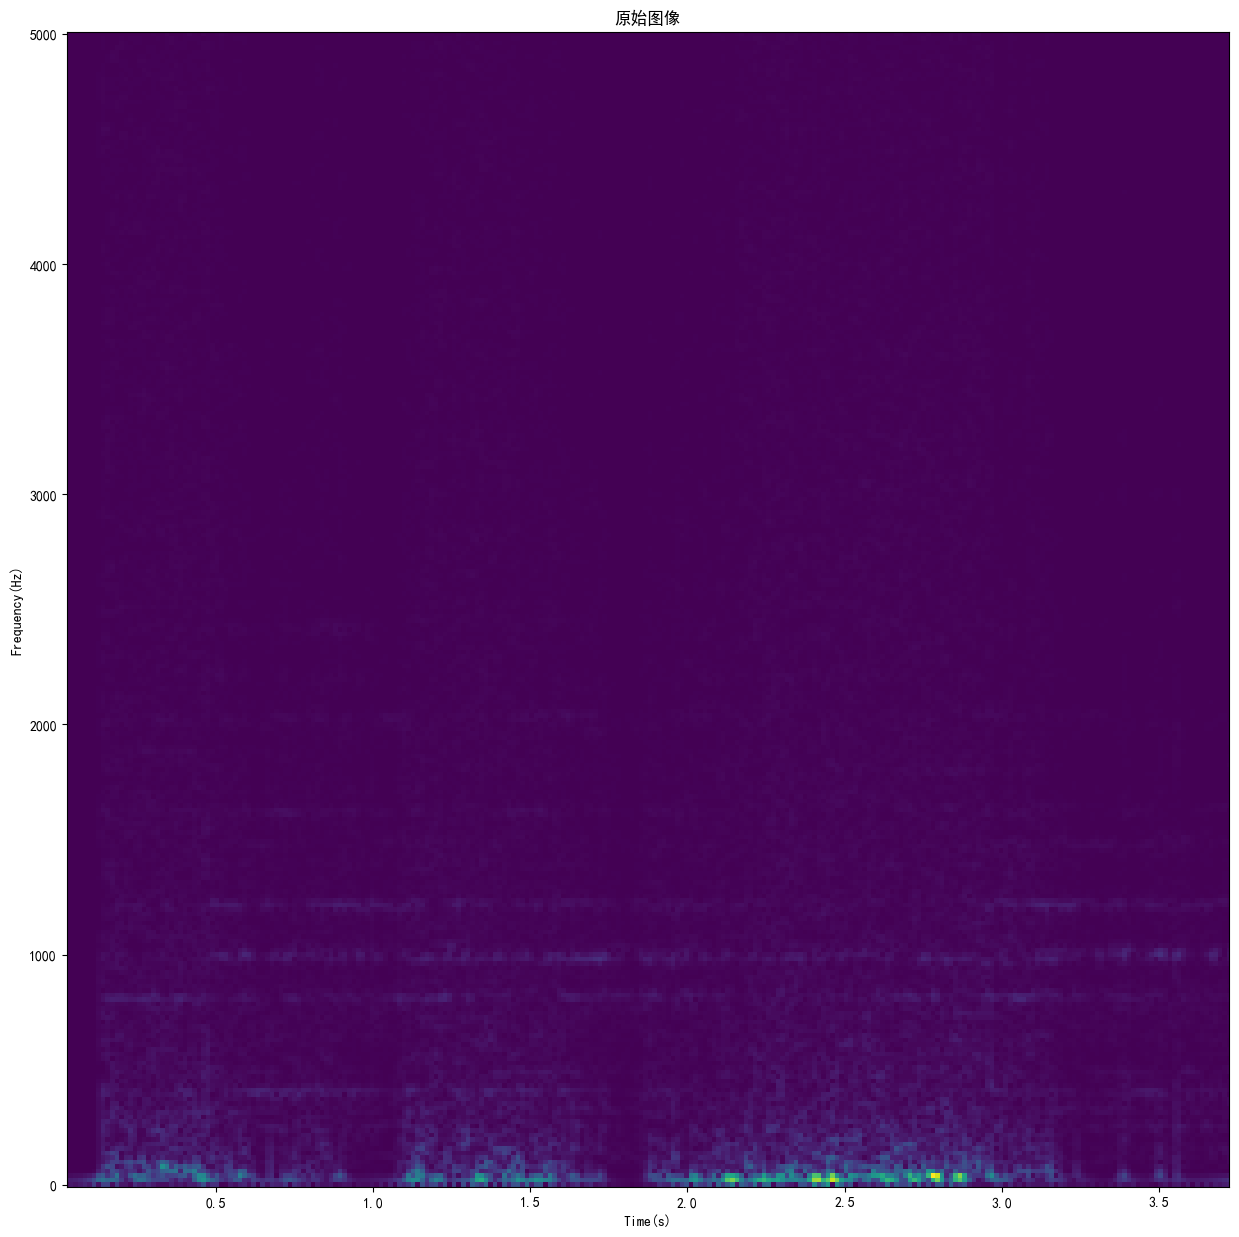

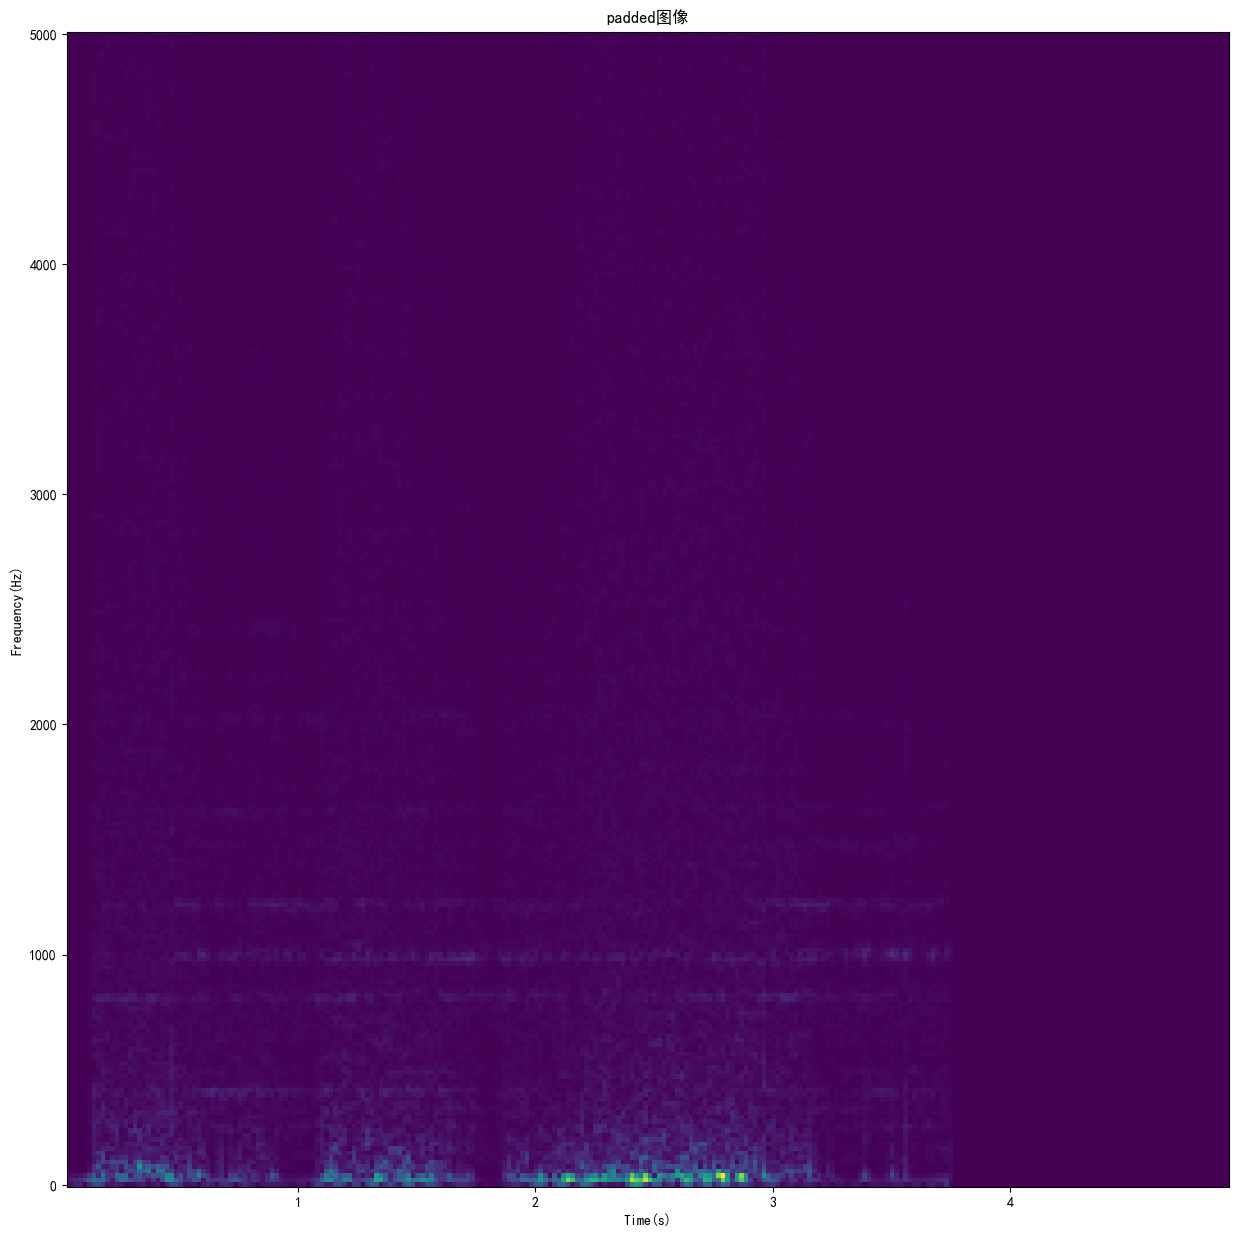

In [13]:
# 将padding前后的数据进行STFT
# 虽然这里用到的方法是动态调节nperseg，noverlap的方法，但是由于padding后，不涉及动态调节nperseg和noverlap，所以没问题，此处就相当于计算了一个合适的nperseg和noverlap
scale = 256
window = 'hamming'
fs = 10000


nperseg, noverlap = get_nperseg_noverlap(len(phase), lfaxis=scale, ltaxis=scale)
flag = True
added_flag = False # 上一次是不是加法操作
padded = False
while(flag):
    nperseg, noverlap, crop, flag, added_flag = temp_check_get_nperseg_noverlap(phase, fs, window,
                                                                                nperseg=nperseg,
                                                                                noverlap=noverlap,
                                                                                lfaxis=scale,
                                                                                ltaxis=scale,
                                                                                added_flag=added_flag)
faxis, taxis, spectrum = get_spectrum_corp(phase, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                           lfaxis=scale, ltaxis=scale, crop=crop)

# 绘制原始图像的短时傅立叶变换的图像
plt.figure(figsize=(15, 15))
plt.pcolormesh(taxis, faxis, np.abs(spectrum))
plt.title("原始图像")
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.xlim([taxis[0], taxis[-1]])
plt.show()

nperseg, noverlap = get_nperseg_noverlap(len(phase_padded), lfaxis=scale, ltaxis=scale)
flag = True
added_flag = False # 上一次是不是加法操作
padded = False
while(flag):
    nperseg, noverlap, crop, flag, added_flag = temp_check_get_nperseg_noverlap(phase_padded, fs, window,
                                                                                nperseg=nperseg,
                                                                                noverlap=noverlap,
                                                                                lfaxis=scale,
                                                                                ltaxis=scale,
                                                                                added_flag=added_flag)
faxis, taxis, spectrum = get_spectrum_corp(phase_padded, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                           lfaxis=scale, ltaxis=scale, crop=crop)

# 绘制padded图像的短时傅立叶变换的图像
plt.figure(figsize=(15, 15))
plt.pcolormesh(taxis, faxis, np.abs(spectrum))
plt.title("padded图像")
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')
plt.xlim([taxis[0], taxis[-1]])
plt.show()
    

**各个函数已完成**